In [1]:
# import lab_utils,
import torch, random
#from torchvision.datasets import CIFAR10 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchnet.meter as meter

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable

from PIL import Image

import json, string
import numpy as np
import time, os
from collections import Counter
import json
import itertools


#from pytorch_utilities import validation_set_split
from pytorch_utilities.plotting import pytorch_model_results

#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
%matplotlib inline

In [2]:
# Verify GPU visibility
!nvidia-smi

Tue Dec  5 14:56:17 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 0000:0A:00.0     Off |                  N/A |
| 33%   53C    P2    53W / 250W |      1MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
def pytorch_model_results(training_values, validation_values, metric='accuracy'):

    # Plot of the loss for training and validation after every epoch
    # --------------------------------------------------------------
    
    if metric == 'accuracy':
        plot_title = 'Training and validation accuracy values after each epoch'
        plot_ylabel = 'Avg Accuracy'
    elif metric == 'loss':
        plot_title = 'Training and validation loss values after each epoch'
        plot_ylabel = 'Avg Loss'

    plt.figure(figsize=(8, 6))

    # training loss
    x = [i+1 for i in range(0, len(training_values)) ]
    y = training_values
    training_plot = 'b^--'
    plt.plot(x, y, training_plot)

    # validation loss
    y = validation_values
    validation_plot = 'r.--'
    plt.plot(x, y, validation_plot)

    # legend, and labels
    plt.legend(['Training','Validation'])
    plt.title(plot_title)
    plt.xlabel('Epoch count')
    plt.ylabel(plot_ylabel)
    plt.xticks(x)

    plt.show()

In [4]:
# Define train_model() with scheduler and
# include loss and accuracy capture after each epoch.
# ---------------------------------------------------

from torch.optim import lr_scheduler

def train_model(network, criterion, optimizer, trainLoader, valLoader, scheduler,lr_step=False, n_epochs=20, use_gpu=True):
    
    training_accuracy_values = []
    validation_accuracy_values = []
    
    training_loss_values = []
    validation_loss_values = []
    
    if use_gpu:
        network = network.cuda()
        criterion = criterion.cuda()
        
    # Training loop.
    for epoch in range(0, n_epochs):
        correct = 0.0
        cum_loss = 0.0
        counter = 0

        # Make a pass over the training data.
        t = tqdm(trainLoader, desc = 'Training epoch %d' % epoch)
        network.train()  # This is important to call before training!
        
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            
            # Added
            # -----
            #if use_gpu:
                #loss = loss.cuda()

            # Backward pass:
            optimizer.zero_grad()
            # Loss is a variable, and calling backward on a Variable will
            # compute all the gradients that lead to that Variable taking on its
            # current value.
            loss.backward() 

            # Weight and bias updates.
            optimizer.step()

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
        
        
        accuracy = 100 * correct / counter
        training_accuracy_values.append(accuracy)
        training_loss_values.append(cum_loss / (1 + i))
        
        # Make a pass over the validation data.
        # -------------------------------------
        
        correct = 0.0
        cum_loss = 0.0
        counter = 0
        t = tqdm(valLoader, desc = 'Validation epoch %d' % epoch)
        network.eval()  # This is important to call before evaluating!
        for (i, (inputs, labels)) in enumerate(t):

            # Wrap inputs, and targets into torch.autograd.Variable types.
            inputs = Variable(inputs)
            labels = Variable(labels)
            
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Forward pass:
            outputs = network(inputs)
            loss = criterion(outputs, labels)

            # logging information.
            cum_loss += loss.data[0]
            max_scores, max_labels = outputs.data.max(1)
            correct += (max_labels == labels.data).sum()
            counter += inputs.size(0)
            t.set_postfix(loss = cum_loss / (1 + i), accuracy = 100 * correct / counter)
            
        accuracy = 100 * correct / counter
        validation_accuracy_values.append(accuracy)
        validation_loss_values.append(cum_loss / (1 + i))
        
        # Scheduler
        # ---------
        if lr_step:
            scheduler.step()
        
    value_lists = [training_accuracy_values,validation_accuracy_values,training_loss_values,validation_loss_values]
    return value_lists

In [19]:
# https://stackoverflow.com/questions/43441673/trying-to-load-a-custom-dataset-in-pytorch

# Using ResNet 18.
# Note: I'm not going to freeze the weights
# since our dataset n > 1000
# -----------------------------------------

# resnet = models.resnet18(pretrained = True)
resnet = models.resnet50(pretrained = True)

### Load training and validation

To create a seperate validation set I used the following bash code:

`
find . -type f -exec dirname {} + | uniq -c | while read n d;do echo "Directory:$d Files:$n Moving random:$(($n / 10))";mkdir -p ../maindir2${d:1};find $d -type f | shuf -n $(($n / 10)) | while read file;do mv $file ../maindir2${d:1}/;done;done
`

I confirmed this successfully did not create duplicates using:

`diff -srq ./trainset/ ./valset/ | grep identical`

In [20]:
# Spectrogram dataset "v1" - 90% training 10% validation
# train_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_90tr10va/trainset/"
# val_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_90tr10va/valset/"

# Spectrogram dataset "v2" - 80% training 10% validation 10% testing (871 taken from training)
train_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/trainset/"
val_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/valset/"
test_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/testset/"

# Original shape is 440x600
transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_set = dset.ImageFolder(train_path,transform=transform)
val_set = dset.ImageFolder(val_path,transform=transform)
test_set = dset.ImageFolder(test_path,transform=transform)

# This didn't work. Only selected one class. Ended up using a bash script to function as trainsetsplit
# train_set, val_set = validation_set_split.validation_split(dataset)


batch_size = 128
batch_size = 16

trainLoader = torch.utils.data.DataLoader(train_set, 
                                          batch_size = batch_size, 
                                          shuffle = True, 
                                          num_workers = 0
                                         )
valLoader = torch.utils.data.DataLoader(val_set, 
                                        batch_size = batch_size, 
                                        shuffle = False, 
                                        num_workers = 0
                                       )
testLoader = torch.utils.data.DataLoader(test_set, 
                                        batch_size = batch_size, 
                                        shuffle = False, 
                                        num_workers = 0
                                       )

In [21]:
class_dict = trainLoader.dataset.class_to_idx
class_dict = {v: k for k, v in class_dict.items()} # reverse key-value mappings

In [22]:
class_dict

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jack_hammer',
 8: 'siren',
 9: 'street_music'}

In [34]:
print(len(trainLoader.dataset))
print(len(valLoader.dataset))
print(len(testLoader.dataset))

6988
873
871


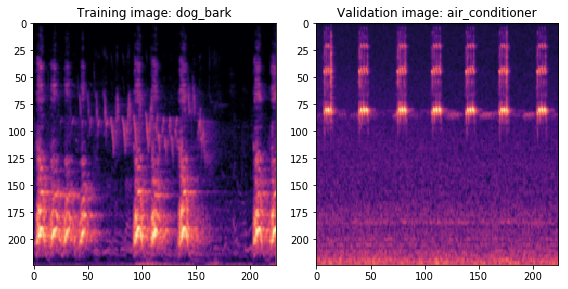

In [51]:
plt.figure(figsize=(8, 4))

sample_tensor, sample_class = trainLoader.dataset[2123]
sample_class = class_dict[sample_class]
sample_arr = sample_tensor.numpy()
sample_arr = np.rollaxis(sample_arr,0,3)
plt.subplot(1,2,1)
plt.imshow(sample_arr, interpolation='nearest')
plt.title(' '.join(["Training image:",sample_class]))

sample_tensor, sample_class = valLoader.dataset[5]
sample_class = class_dict[sample_class]
sample_arr = sample_tensor.numpy()
sample_arr = np.rollaxis(sample_arr,0,3)
plt.subplot(1,2,2)
plt.imshow(sample_arr, interpolation='nearest')
plt.title(' '.join(["Validation image:",sample_class]))

plt.tight_layout()

In [52]:
val_class_list = [valLoader.dataset[idx][1] for idx in range(0, len(valLoader.dataset))]
train_class_list = [trainLoader.dataset[idx][1] for idx in range(0, len(trainLoader.dataset))]
test_class_list = [testLoader.dataset[idx][1] for idx in range(0, len(testLoader.dataset))]

In [53]:
# Sanity check on class distributions
print(Counter(val_class_list))
print(Counter(train_class_list))
print(Counter(test_class_list))

Counter({0: 100, 2: 100, 3: 100, 4: 100, 5: 100, 7: 100, 9: 100, 8: 93, 1: 43, 6: 37})
Counter({0: 800, 2: 800, 3: 800, 4: 800, 5: 800, 7: 800, 9: 800, 8: 744, 1: 344, 6: 300})
Counter({0: 100, 2: 100, 3: 100, 4: 100, 5: 100, 7: 100, 9: 100, 8: 92, 1: 42, 6: 37})


Could be worth removing classes 1 and 6 (car_horn, gun_shot, and siren respectively) since the remaining classes have the same number of observations (minus 8 - siren, which is pretty close).

### Customize ResNet

In [23]:
# OPTIONAL #1: Replace FC layer so 
# model only predicts two variables
# ---------------------------------

print(resnet.fc)
total_classes = len(class_dict.keys())
resnet.fc = nn.Linear(resnet.fc.in_features, total_classes) # Our dataset has 2 classes
print(resnet.fc)

Linear (2048 -> 1000)
Linear (2048 -> 10)


### Train

In [24]:
import time

t0 = time.time()

# ------------------------------------------------------
# Retrain resnet on our dataset
# ------------------------------------------------------


criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(resnet.parameters(), lr=0.02, momentum=0.9, weight_decay=0.0005)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Concerned that the momentum is too high for this because the validation is oscillating quite a bit
# Going to lower the learning rate
lr = 0.001
momentum = 0.9
weight_decay = 0.0005
optimizer = optim.SGD(resnet.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
exp_lr_scheduler = None

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.5)

n_epochs = 11
training_values = train_model(resnet, criterion, optimizer, trainLoader, valLoader, exp_lr_scheduler,lr_step=False, n_epochs = n_epochs, use_gpu=True)

# ------------------------------------------------------
# Time
# ------------------------------------------------------

t1 = time.time()
total = t1-t0

Validation epoch 10: 100%|██████████| 55/55 [00:06<00:00,  8.63it/s, accuracy=96.9, loss=0.135] 


In [26]:
training_values[1].index(np.max(training_values[1]))

9

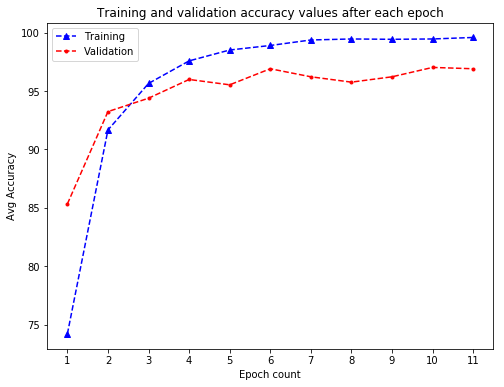

In [27]:
pytorch_model_results(training_values[0],training_values[1],metric='accuracy')

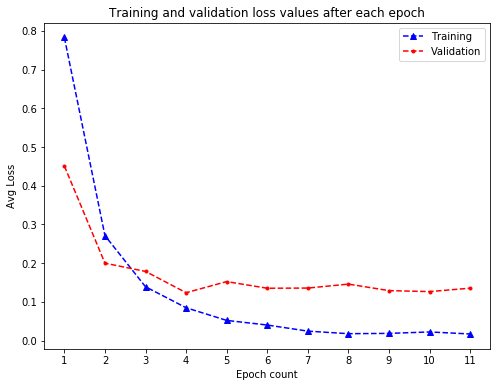

In [28]:
pytorch_model_results(training_values[2],training_values[3],metric='loss')

### Save model

In [29]:
# Save model parameters
# ---------------------

# Naming convention:
# [model]_[dataset version]_[data type]_[epoch]_[final accuracy %]
name = 'resnet50_v2_melspect_11'
dir_path = "/data/datasets/sound_datasets/pytorch_UrbanSound8K/saved_models/cvr_final_project/"
extension = '.pt'
PATH = ''.join([dir_path,name,extension])
torch.save(resnet.state_dict(), PATH)

# Save hyper parameters and results
# ---------------------------------

experiment_log = {
    'lr':lr,
    'momentum':momentum,
    'weight_decay':weight_decay,
    'n_epochs':n_epochs,
    'training_accuracy':training_values[0],
    'validation_accuracy':training_values[1],
    'training_loss':training_values[2],
    'validation_loss':training_values[3],
    'optimizer':str(type(optimizer)),
    'criterion':str(type(criterion)),
    'train_time':total/60
}

# with open(''.join([dir_path,name,'.txt']), 'w') as file:
#      file.write(json.dumps(experiment_log))
json.dump(experiment_log, open(''.join([dir_path,name,'.txt']),'w'))

### Load model

In [21]:
resnet = models.resnet50(pretrained = True)
print(resnet.fc)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
print(resnet.fc)
resnet.load_state_dict(torch.load('/data/datasets/sound_datasets/pytorch_UrbanSound8K/saved_models/cvr_final_project/resnet50_v2_melspect_15_968.pt',
                                         map_location=lambda storage, 
                                         loc: storage
                                        )
                             )

Linear (2048 -> 1000)
Linear (2048 -> 10)


### Load log

In [17]:
log_path = '/data/datasets/sound_datasets/pytorch_UrbanSound8K/saved_models/cvr_final_project/resnet50_v2_melspect_100.txt'
# with open(log_path, 'r') as f:
#     model_log = f.read()
    #self.whip = ast.literal_eval(s)
    
model_log = json.load(open(log_path))

In [18]:
model_log

{'criterion': "<class 'torch.nn.modules.loss.CrossEntropyLoss'>",
 'lr': 0.001,
 'momentum': 0.9,
 'n_epochs': 100,
 'optimizer': "<class 'torch.optim.sgd.SGD'>",
 'train_time': 149.4076722105344,
 'training_accuracy': [74.24155695477963,
  92.18660560961648,
  95.93589009730967,
  97.23812249570693,
  98.62621637092158,
  99.12707498568976,
  99.17000572409846,
  99.58500286204922,
  99.55638236977676,
  99.22724670864339,
  99.54207212364052,
  99.88551803091013,
  99.67086433886662,
  99.75672581568404,
  99.8282770463652,
  99.85689753863767,
  99.9570692615913,
  99.88551803091013,
  99.9141385231826,
  99.94275901545507,
  99.81396680022897,
  99.88551803091013,
  99.92844876931883,
  99.9570692615913,
  99.97137950772753,
  99.98568975386377,
  99.92844876931883,
  99.9570692615913,
  99.9570692615913,
  99.98568975386377,
  99.98568975386377,
  99.98568975386377,
  99.9570692615913,
  100.0,
  100.0,
  99.94275901545507,
  99.97137950772753,
  99.9570692615913,
  99.94275901545

### Test

In [20]:
resnet.cuda().eval()
confusion_matrix = meter.ConfusionMeter(total_classes)
for ii, data in enumerate(testLoader):
    input, label = data
    val_input = Variable(input, volatile=True).cuda()
    val_label = Variable(label.type(torch.LongTensor), volatile=True).cuda()
    score = resnet(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))
print(confusion_matrix.conf)

# Hack together some code to pull out the misclassified examples...
# resnet.cuda().eval()
# np.argmax(resnet(val_input).data.squeeze().cpu().squeeze().numpy(),1

[[100   0   0   0   0   0   0   0   0   0]
 [  0  40   0   0   0   0   0   0   0   2]
 [  1   0  96   0   0   0   0   0   0   3]
 [  1   0   2  92   0   1   0   0   0   4]
 [  0   0   0   0  93   0   0   7   0   0]
 [  1   0   0   0   1  98   0   0   0   0]
 [  0   0   0   0   0   0  37   0   0   0]
 [  0   0   0   0   0   0   0  98   0   2]
 [  0   0   0   0   0   1   0   0  91   0]
 [  0   0   2   0   0   0   0   1   0  97]]


In [74]:
def plot_confusion_matrix(cm, classes, cmap,
                          normalize=False,
                          title='Confusion matrix',
                          font_family='Sans',
                          font_properties=[26,16,17,20,40,20],
                          save_fig=False
                          ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    title_font_size = font_properties[0]
    cell_font_size = font_properties[1]
    tick_font_size = font_properties[2]
    label_font_size = font_properties[3]
    cbar_font_size = font_properties[3]
    x_rotation = font_properties[4]
    cbar_pad = font_properties[5]
    family = font_family
    ha = 'right'
    
    if normalize:
        cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm_n.max() / 2.
    else:
        thresh = cm.max() / 2.
    
    fig = plt.figure(figsize=(19,19), dpi=400)
    ax1 = fig.add_subplot(1, 1, 1,  aspect='equal')
    
    if normalize:
        plt.imshow(cm_n, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        
    plt.title(title, size=title_font_size, family=family)
    
    # Main plot
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=x_rotation, size=tick_font_size, family=family,  ha=ha)
    plt.yticks(tick_marks, classes, size=tick_font_size, family=family)

    if normalize:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     size=cell_font_size,
                     color="white" if cm_n[i, j] > thresh else "black", 
                     family=family
                    )
    else:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     size=cell_font_size,
                     color="white" if cm[i, j] > thresh else "black",
                     family=family
                    )   

    plt.ylabel('True Label', size=label_font_size, family=family)
    plt.xlabel('Predicted Label', size=label_font_size, family=family)
    
    # Colorbar legend
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    cbar = plt.colorbar(cax=cax)
    cbar.ax.get_yaxis().labelpad = cbar_pad
    #cbar.ax.tick_params(family=family)
    cbar.set_label('Class Sample Proportion', rotation=270, size=cbar_font_size, family=family)
    
    if save_fig:
        savefig_name = ''.join(["./manuscript/figures/",'testset_cm','.png'])
        plt.savefig(savefig_name)
    

    
    #plt.tight_layout()

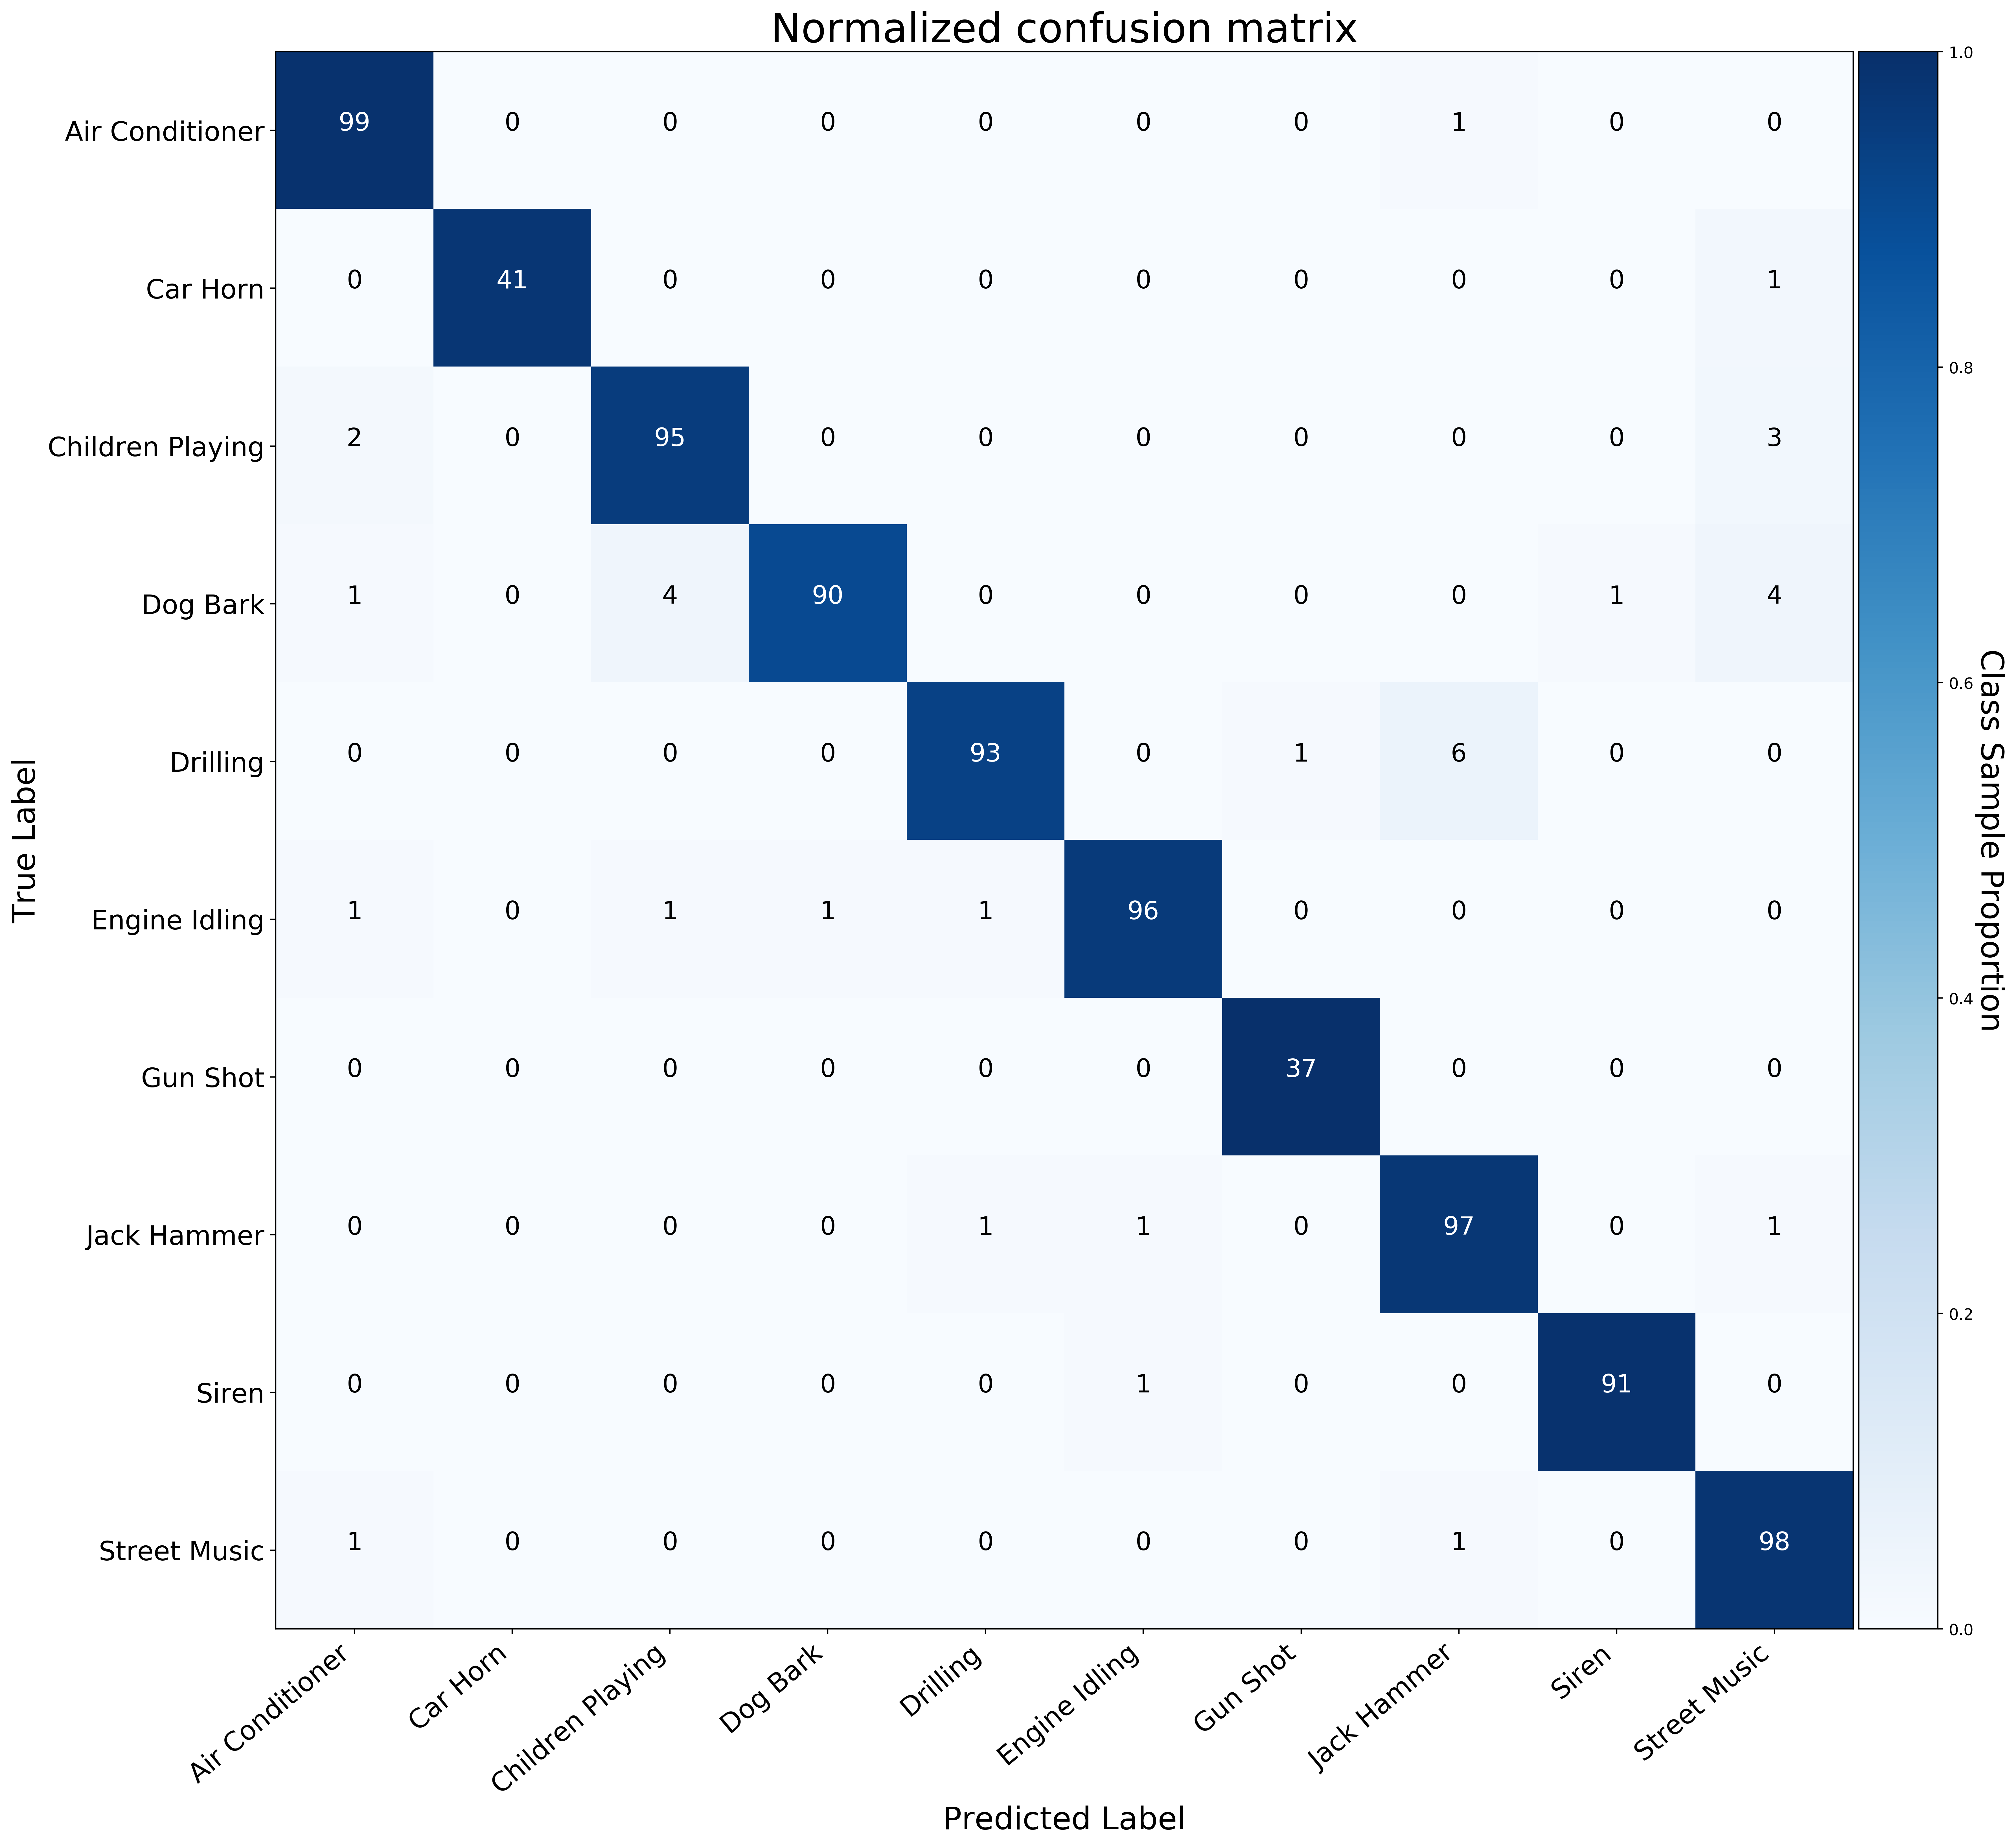

In [75]:
# Plot normalized confusion matrix
class_names = [name.replace('_',' ').title() for name in class_dict.values()]

plot_confusion_matrix(confusion_matrix.conf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix', cmap='Blues',save_fig=True)

# Evaluate on live samples

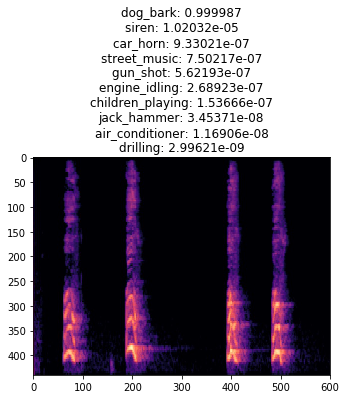

In [29]:
import torch.nn.functional as F
#imagenetClasses = {int(idx): entry[1] for (idx, entry) in json.load(open('imagenet_class_index.json')).items()}

# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('/data/datasets/sound_datasets/pytorch_UrbanSound8K/image/testset/me_barking_171128.jpg').convert('RGB')

# Try your own image here.
inputVar =  Variable(transform(image).unsqueeze(0))
predictions = resnet(inputVar.cuda())

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions.cpu())).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

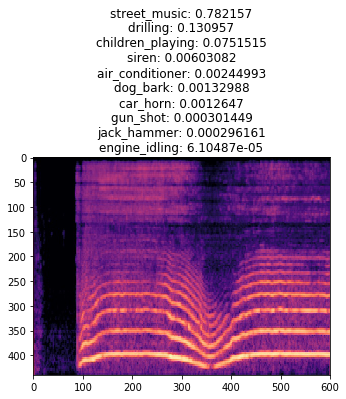

In [30]:
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('/data/datasets/sound_datasets/pytorch_UrbanSound8K/image/testset/me_drilling-sound_171128.jpg').convert('RGB')

# Try your own image here.
inputVar =  Variable(transform(image).unsqueeze(0))
predictions = resnet(inputVar.cuda())

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions.cpu())).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

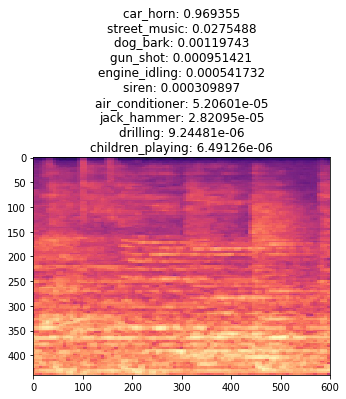

In [87]:
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/live_examples/171128_mudhouse_44100_1_001_music-noise-DURATION.jpg').convert('RGB')

# Try your own image here.
inputVar =  Variable(transform(image).unsqueeze(0))
predictions = resnet(inputVar.cuda())

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions.cpu())).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

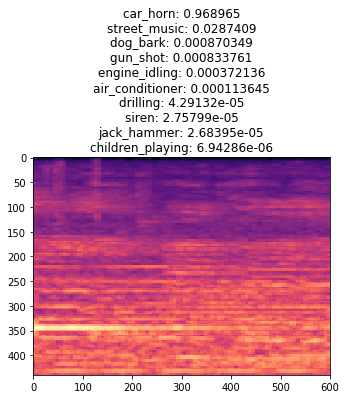

In [89]:
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/live_examples/171128_mudhouse_44100_1_002_music-noise-DURATION.jpg').convert('RGB')

# Try your own image here.
inputVar =  Variable(transform(image).unsqueeze(0))
predictions = resnet(inputVar.cuda())

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions.cpu())).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

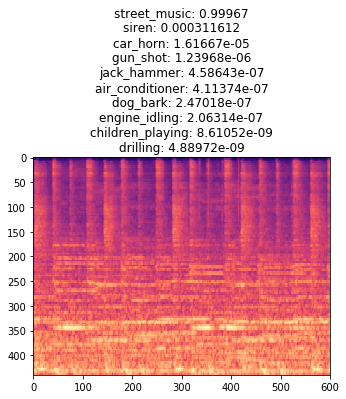

In [90]:
# Never forget to set in evaluation mode so Dropoff layers don't add randomness.
resnet.eval()

# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image = Image.open('/data/datasets/sound_datasets/pytorch_UrbanSound8K/image_80tr10va10te/live_examples/171128_mudhouse_44100_4_002_music-noise-DURATION.jpg').convert('RGB')

# Try your own image here.
inputVar =  Variable(transform(image).unsqueeze(0))
predictions = resnet(inputVar.cuda())

# 4. Decode the top 10 classes predicted for this image.
# ------------------------------------------------------

# We need to apply softmax because the model outputs the last linear layer activations and not softmax scores.
probs, indices = (-F.softmax(predictions.cpu())).data.sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [class_dict[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 5. Show image and predictions
# -----------------------------

# plt.title(string.join(preds, '\n'))
plt.title('\n'.join(preds))
plt.imshow(image);

### TSNE

In [120]:
# Using the feature extractor example provided by Vicente, with some slight modifications.
# ----------------------------------------------------------------------------------------
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.base_network = resnet.cuda() # need CUDA to use GPU
        #self.fc = 0
    
    # Additions
    #def classifier(self, feature_vector):
        #x = nn.Linear(feature_vectors.size()[0], n_classes)
        
    def forward(self, image):
        x = self.base_network.conv1(image)
        x = self.base_network.bn1(x)
        x = self.base_network.relu(x)
        x = self.base_network.maxpool(x)

        x = self.base_network.layer1(x)
        x = self.base_network.layer2(x)
        x = self.base_network.layer3(x)
        x = self.base_network.layer4(x)
        x = self.base_network.avgpool(x)
        features = x.view(x.size(0), -1)
        
        return features

In [121]:
# Build new training dataset from our ResNet feature extractor
# ------------------------------------------------------------

#torch.cuda.comm.broadcast
#torch.cuda.set_device(gpus[0])

label_list = []
FeatureExtractor().eval()
for i, data in enumerate(trainLoader, 0):
        
        # get the inputs
        inputs, label = data
        inputs = inputs.cuda()
        train_feature_set = FeatureExtractor().forward(Variable(inputs))
        
        if i > 0:
            tensor_stack = torch.cat((tensor_stack, train_feature_set.data))
        else:
            tensor_stack = train_feature_set.data.clone()
            
        label_list.append(label[0])

In [232]:
pd_target = tensor_stack.cpu().numpy() # need to move tensors to cpu to cast as numpy array
df = pd.DataFrame(pd_target)
df['class'] = label_list

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@virginia.edu</div>